In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install -q --upgrade pip
!pip install -q -U transformers
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U peft
!pip install -q -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.9 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.2.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
pylibcudf-cu12 25.2.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, pipeline, logging
from transformers.models.gemma3 import Gemma3ForCausalLM
from datasets import Dataset
from peft import LoraConfig, PeftConfig, PeftModel
from trl import SFTTrainer, SFTConfig
import bitsandbytes as bnb
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, auc, f1_score)
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import json

If doesnt work, try restarting kernel

In [4]:
def define_device():
    print(f"PyTorch version: {torch.__version__}", end=" -- ")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        print("using MPS device on macOS")
        return torch.device("mps")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"using {device}")
    return device

In [5]:
compute_dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16
print(f"Using compute dtype {compute_dtype}")
device = define_device()
print(f"Operating on {device}")

Using compute dtype torch.float16
PyTorch version: 2.5.1+cu121 -- using cuda
Operating on cuda


In [6]:
GEMMA_PATH = "/kaggle/input/gemma-3/transformers/gemma-3-1b-it/1"
model = Gemma3ForCausalLM.from_pretrained(
    GEMMA_PATH,
    torch_dtype=compute_dtype,
    attn_implementation="eager",
    low_cpu_mem_usage=True,
    device_map=device
)

max_seq_length = 8192
tokenizer = AutoTokenizer.from_pretrained(GEMMA_PATH, max_seq_length=max_seq_length, device_map=device)
EOS_TOKEN = tokenizer.eos_token

`torch_dtype` is deprecated! Use `dtype` instead!


In [7]:
# Load datasets
# ============================================================
import csv
paths = [
    "/kaggle/input/sentiment-uci-dataset/amazon_cells_labelled.txt",
    "/kaggle/input/sentiment-uci-dataset/imdb_labelled.txt",
    "/kaggle/input/sentiment-uci-dataset/yelp_labelled.txt"
]
dataset_names = ["amazon", "imdb", "yelp"]
dfs = []
for path, name in zip(paths, dataset_names):
    df_tmp = pd.read_csv(path, sep="\t", names=["text", "label"], encoding="utf-8", 
                          quoting=csv.QUOTE_NONE, engine="python")
    df_tmp["source"] = name
    dfs.append(df_tmp)

df = pd.concat(dfs, ignore_index=True)
df["label"] = df["label"].astype(int)
df["sentiment"] = df["label"].map({0: "negative", 1: "positive"})
df = df.drop(columns=["label"])

dfs_balanced = []
for name in dataset_names:
    df_src = df[df["source"] == name]
    df_pos = df_src[df_src["sentiment"] == "positive"].sample(500, random_state=42)
    df_neg = df_src[df_src["sentiment"] == "negative"].sample(500, random_state=42)
    dfs_balanced.append(pd.concat([df_pos, df_neg], ignore_index=True))

df = pd.concat(dfs_balanced, ignore_index=True)
print("Final dataset size:", len(df))

Final dataset size: 3000


In [8]:
#Data for Kfold
df_kfold = df.copy()

df["strat_key"] = df["source"] + "_" + df["sentiment"]

X_train, X_temp = train_test_split(
    df,
    test_size=0.30,                   # 30% goes to (eval + test)
    random_state=42,
    stratify=df["strat_key"]
)
X_eval, X_test = train_test_split(
    X_temp,
    test_size=2/3,                    # 20% out of the original dataset
    random_state=42,
    stratify=X_temp["strat_key"]
)

X_train = X_train.drop(columns=["strat_key"])
X_eval = X_eval.drop(columns=["strat_key"])
X_test = X_test.drop(columns=["strat_key"])
y_test_true = X_test["sentiment"].values

In [ ]:
X_amazon = df[df["source"] == "amazon"].reset_index(drop=True)
X_imdb   = df[df["source"] == "imdb"].reset_index(drop=True)
X_yelp   = df[df["source"] == "yelp"].reset_index(drop=True)

X_amazon_train, X_amazon_eval = train_test_split(
    X_amazon,
    test_size=0.20,                  
    random_state=42,
    stratify=X_amazon["strat_key"])

X_imdb_train, X_imdb_eval = train_test_split(
    X_imdb,
    test_size=0.20,                  
    random_state=42,
    stratify=X_imdb["strat_key"])

X_yelp_train, X_yelp_eval = train_test_split(
    X_yelp,
    test_size=0.20,                  
    random_state=42,
    stratify=X_yelp["strat_key"])

X_amazon = X_amazon.drop(columns=["strat_key"])
X_imdb = X_imdb.drop(columns=["strat_key"])
X_yelp = X_yelp.drop(columns=["strat_key"])

X_amazon_train = X_amazon_train.drop(columns=["strat_key"])
X_amazon_eval = X_amazon_eval.drop(columns=["strat_key"])
X_imdb_train = X_imdb_train.drop(columns=["strat_key"])
X_imdb_eval = X_imdb_eval.drop(columns=["strat_key"])    
X_yelp_train = X_yelp_train.drop(columns=["strat_key"])
X_yelp_eval = X_yelp_eval.drop(columns=["strat_key"])

y_test_true_amazon = X_amazon["sentiment"].values
y_test_true_imdb = X_imdb["sentiment"].values
y_test_true_yelp = X_yelp["sentiment"].values

In [ ]:
#IMDB50k

#importing the training data
imdb50k_data=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
print(imdb50k_data.shape)
imdb50k_data.head(10)

In [ ]:
imdb50k_data['sentiment'].value_counts()

In [ ]:
from bs4 import BeautifulSoup
import re
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb50k_data['review']=imdb50k_data['review'].apply(denoise_text)

In [ ]:
train_reviews, test_reviews = train_test_split(
    imdb50k_data,
    test_size=0.2,                   
    random_state=42,
    stratify=imdb50k_data["sentiment"]
)

In [ ]:
train_reviews = train_reviews.rename(columns={"review": "text"})
test_reviews = test_reviews.rename(columns={"review": "text"})

In [ ]:
y_test_reviews = test_reviews["sentiment"].values

In [ ]:
train_10k, _ = train_test_split(
    train_reviews,
    train_size=10000,
    random_state=42,
    stratify=train_reviews["sentiment"]
)

In [ ]:
train_10k['sentiment'].value_counts()

In [ ]:
'''
# Split: 80% for k-fold, 20% for final test
df["strat_key"] = df["source"] + "_" + df["sentiment"]
df_kfold, X_test = train_test_split(df, test_size=0.20, random_state=42, stratify=df["strat_key"])
df_kfold.drop(columns=["strat_key"], inplace=True)
X_test.drop(columns=["strat_key"], inplace=True)

y_test_true = X_test["sentiment"].values
print("\nK-Fold + Test split:")
print(f"K-Fold dataset: {len(df_kfold)}")
print(f"Test dataset: {len(X_test)}")
'''

In [ ]:
print(f"K-Fold dataset: {len(df_kfold)}")
print(f"Train dataset: {len(X_train)}")
print(f"Eval dataset: {len(X_eval)}")
print(f"Test dataset: {len(X_test)}")

In [ ]:
# Prompt generation
# ============================================================
# Zero Shot
def generate_train_prompt(data_point):
    return f"""
    Analyze the sentiment of the text enclosed in the brackets. 
    Determine if it is "positive" or "negative", and return the sentiment label along with a probability score (0-1).
    Format: [label],[probability]
    Where 1 means very positive and 0 means very negative.
    Only return the label and probability, nothing else.
    [{data_point["text"]}] = {data_point["sentiment"]},
    """.strip() + EOS_TOKEN

def generate_test_prompt(data_point):
    return f"""
    Analyze the sentiment of the text enclosed in the brackets. 
    Determine if it is "positive" or "negative", and return the sentiment label along with a probability score (0-1).
    Format: [label],[probability]
    Where 1 means very positive and 0 means very negative.
    Only return the label and probability, nothing else.
    [{data_point["text"]}] = 
    """.strip()

In [ ]:
# Prompt generation
# ============================================================
# One Shot
EXAMPLE_TEXT = "The overall experience was excellent and I am very satisfied."
EXAMPLE_LABEL = "positive"
EXAMPLE_PROB  = "1"  # you choose this

def generate_train_prompt(data_point):
    return f"""
    Analyze the sentiment of the text enclosed in the brackets. 
    Determine if it is "positive" or "negative", and return the sentiment label along with a probability score (0-1).
    Format: [label],[probability]
    Where 1 means very positive and 0 means very negative.
    Only return the label and probability, nothing else.

    [Example]
    [{EXAMPLE_TEXT}] = {EXAMPLE_LABEL},{EXAMPLE_PROB}

    [Task]
    [{data_point["text"]}] = {data_point["sentiment"]},
    """.strip() + EOS_TOKEN

def generate_test_prompt(data_point):
    return f"""
    Analyze the sentiment of the text enclosed in the brackets. 
    Determine if it is "positive" or "negative", and return the sentiment label along with a probability score (0-1).
    Format: [label],[probability]
    Where 1 means very positive and 0 means very negative.
    Only return the label and probability, nothing else.

    [Example]
    [{EXAMPLE_TEXT}] = {EXAMPLE_LABEL},{EXAMPLE_PROB}

    [Task]
    [{data_point["text"]}] = 
    """.strip()

In [ ]:
# Prompt generation
# ============================================================
# Few Shot, # 2 examples (negative and positive for each dataset)
EXAMPLES = [
    # Amazon: product reviews
    ("The product works well and matches the description.", "positive", "1"), #0.8
    ("The product is really bad and the quality feels very cheap.", "negative", "0"), #0.05

    # IMDB: movie reviews
    ("The movie was engaging and the acting was strong.", "positive", "1"), #0.9
    ("The movie was boring and the performances were weak.", "negative", "0"), #0.25

    # Yelp: local business/restaurant reviews
    ("The restaurant had friendly service and tasty food.", "positive", "1"), #0.95
    ("The restaurant had slow service and bland food.", "negative", "0"), #0.05
]

def format_examples():
    lines = []
    for text, label, prob in EXAMPLES:
        lines.append(f"[{text}] = {label},{prob}")
    return "\n    ".join(lines)

def generate_train_prompt(data_point):
    return f"""
    Analyze the sentiment of the text enclosed in the brackets. 
    Determine if it is "positive" or "negative", and return the sentiment label along with a probability score (0-1).
    Format: [label],[probability]
    Where 1 means very positive and 0 means very negative.
    Only return the label and probability, nothing else.

    [Examples]
    {format_examples()}

    [Task]
    [{data_point["text"]}] = {data_point["sentiment"]},
    """.strip() + EOS_TOKEN

def generate_test_prompt(data_point):
    return f"""
    Analyze the sentiment of the text enclosed in the brackets. 
    Determine if it is "positive" or "negative", and return the sentiment label along with a probability score (0-1).
    Format: [label],[probability]
    Where 1 means very positive and 0 means very negative.
    Only return the label and probability, nothing else.

    [Examples]
    {format_examples()}

    [Task]
    [{data_point["text"]}] = 
    """.strip()


In [9]:
def create_n_shot_prompt_generator(examples):
    instruction = """Analyze the sentiment of the text enclosed in the brackets. 
    Determine if it is "positive" or "negative", and return the sentiment label along with a probability score (0-1).
    Format: [label],[probability]
    Where 1 means very positive and 0 means very negative.
    Only return the label and probability, nothing else."""
    
    example_prompts = []
    if not examples.empty:
        for _, row in examples.iterrows():
            prob = 1 if row['sentiment'] == 'positive' else 0
            example_prompts.append(f"[{row['text']}] = {row['sentiment']},{prob}")
    
    examples_block = "\n\n".join(example_prompts)
    
    def generate_prompt(data_point):
        if examples_block:
            return f"{instruction}\n\n{examples_block}\n\n[{data_point['text']}] = ".strip()
        else:
            return f"{instruction}\n\n[{data_point['text']}] = ".strip()
            
    return generate_prompt

In [10]:
def evaluate_with_roc(y_true, y_pred, y_pred_proba=None, fold_num=None):
    """Evaluate with accuracy, F1, and ROC-AUC."""
    label_mapping = {'negative': 0, 'positive': 1}
    y_true_num = np.array([label_mapping.get(label, -1) for label in y_true])
    y_pred_num = np.array([label_mapping.get(label, -1) for label in y_pred])
    
    mask = y_true_num != -1
    y_true_num = y_true_num[mask]
    y_pred_num = y_pred_num[mask]
    
    if y_pred_proba is not None:
        y_pred_proba = y_pred_proba[mask]
    
    accuracy = accuracy_score(y_true_num, y_pred_num)
    f1 = f1_score(y_true_num, y_pred_num, average='macro') #'weighted'
    
    results = {
        'accuracy': accuracy,
        'f1_score': f1,
        'classification_report': classification_report(y_true_num, y_pred_num, 
                                                       labels=[0, 1], target_names=["negative", "positive"]),
        'confusion_matrix': confusion_matrix(y_true_num, y_pred_num, labels=[0, 1]).tolist()
    }
    
    try:
        if y_pred_proba is not None:
            roc_auc = roc_auc_score(y_true_num, y_pred_proba)
            fpr, tpr, _ = roc_curve(y_true_num, y_pred_proba)
        else:
            roc_auc = roc_auc_score(y_true_num, y_pred_num)
            fpr, tpr, _ = roc_curve(y_true_num, y_pred_num)
        
        results['roc_auc'] = roc_auc
        results['fpr'] = fpr.tolist()
        results['tpr'] = tpr.tolist()
    except Exception as e:
        results['roc_auc'] = None
        results['fpr'] = None
        results['tpr'] = None
    
    fold_str = f" (Fold {fold_num})" if fold_num else ""
    print(f"\n{'='*50}")
    print(f"Results{fold_str}")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if results['roc_auc']:
        print(f"ROC-AUC: {results['roc_auc']:.4f}")
    print("\nClassification Report:")
    print(results['classification_report'])
    print("\nConfusion Matrix:")
    print(np.array(results['confusion_matrix']))
    
    return results

In [ ]:
'''
def predict_with_proba(X_test, model, tokenizer, device=device, max_new_tokens=10, temperature=0.0):
    """Predict sentiment with probability scores from model output."""
    y_pred = []
    y_proba = []
    for i in tqdm(range(len(X_test)), desc="Predicting"):
        prompt = X_test.iloc[i]["text"]
        input_ids = tokenizer(prompt, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model.generate(
                **input_ids, 
                max_new_tokens=max_new_tokens, 
                temperature=temperature,
            )
        
        result = tokenizer.decode(outputs[0], skip_special_tokens=True)
        result_lower = result.lower().split("=")[-1].strip()
        
        # Parse the result - expecting format: "positive,0.95" or "negative,0.1"
        pred = "negative"
        prob = 0.5  # default probability
        
        if "positive" in result_lower:
            pred = "positive"
        elif "negative" in result_lower:
            pred = "negative"
        
        # Try to extract probability score
        try:
            parts = result_lower.replace("positive", "").replace("negative", "").split(",")
            for part in parts:
                part = part.strip()
                if part:
                    try:
                        score = float(part)
                        if 0 <= score <= 1:
                            prob = score
                            break
                    except:
                        pass
        except:
            pass
        
        y_pred.append(pred)
        y_proba.append(prob)
    
    return y_pred, np.array(y_proba)
'''

In [11]:
def predict_with_proba(X_test, model, tokenizer, device=device, max_new_tokens=10, temperature=0.0):
    """Predict sentiment with probability scores from model output."""
    y_pred = []
    y_proba = []
    
    for i in tqdm(range(len(X_test)), desc="Predicting"):
        prompt = X_test.iloc[i]["text"]
        input_ids = tokenizer(prompt, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model.generate(
                **input_ids, 
                max_new_tokens=max_new_tokens, 
                temperature=temperature,
            )
        
        result = tokenizer.decode(outputs[0], skip_special_tokens=True)
        result_lower = result.lower().split("=")[-1].strip()
        
        # Parse the result - expecting format: "positive,0.95" or "negative,0.1"
        pred = "negative"
        prob = 0.0  # default probability
        
        if "positive" in result_lower:
            pred = "positive"
        elif "negative" in result_lower:
            pred = "negative"
        
        # Try to extract probability score
        prob_found = False
        try:
            # Remove the label words first
            clean_result = result_lower.replace("positive", "").replace("negative", "").replace('"', '')
            # Look for comma-separated values
            parts = clean_result.split(",")
            for part in parts:
                part = part.strip().strip("[](){}").strip()
                if part:
                    try:
                        score = float(part)
                        if 0 <= score <= 1:
                            prob = score
                            prob_found = True
                            break
                    except:
                        pass
        except:
            pass
        
        # If no valid probability found, use prediction-based default
        if not prob_found:
            prob = 1.0 if pred == "positive" else 0.0
            
        y_pred.append(pred)
        y_proba.append(prob)
    
    print(f"\nProbability distribution:")
    print(f"  Min: {np.min(y_proba):.3f}, Max: {np.max(y_proba):.3f}, Mean: {np.mean(y_proba):.3f}")
    print(f"  Unique values: {len(np.unique(y_proba))}")
    
    return y_pred, np.array(y_proba)

In [12]:
def evaluate_performance(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    return {
        'accuracy': report.get('accuracy', 0),
        'positive_recall': report.get('positive', {}).get('recall', 0),
        'negative_recall': report.get('negative', {}).get('recall', 0)
    }

In [ ]:
# 2. EXPERIMENT 1: RANDOM FEW-SHOT PERFORMANCE (0-10 SHOTS)
# ===================================================================
print(f"\n{'='*25}\n   EXPERIMENT 1: RANDOM FEW-SHOT (0-10)\n{'='*25}")

N_RUNS = 5
BASE_RANDOM_STATE = 42
exp1_results = []

for run_id in range(N_RUNS):
    print(f"\n--- Starting Run {run_id + 1}/{N_RUNS} ---")
    
    # Select a new pool of 10 random examples for this run
    # Stratified by source to maintain balance
    examples_pool, _ = train_test_split(
        X_train, train_size=10, 
        random_state=BASE_RANDOM_STATE + run_id, 
        stratify=X_train['source']
    )

    for n_shots in range(11): # 0 to 10 shots
        examples_df = examples_pool.iloc[:n_shots]
        
        prompt_generator = create_n_shot_prompt_generator(examples_df)
        X_test_prompts = X_test.apply(prompt_generator, axis=1)
        X_test_df = pd.DataFrame(X_test_prompts, columns=["text"])
        
        y_test_pred, _ = predict_with_proba(X_test_df, model, tokenizer)
        results = evaluate_performance(y_test_true, y_test_pred)
        
        exp1_results.append({'run': run_id, 'n_shots': n_shots, 'accuracy': results['accuracy']})

# --- Convert to DataFrame for plotting ---
exp1_df = pd.DataFrame(exp1_results)
exp1_df['accuracy_pct'] = exp1_df['accuracy'] * 100 # Convert to percentage

In [13]:
print(f"\n{'='*25}\n   EXPERIMENT 2: BIASED PROMPTING (1-5)\n{'='*25}")
N_RUNS = 5
BASE_RANDOM_STATE = 42

exp2_results = []
shots_to_test_exp2 = [1, 5]

for run_id in range(N_RUNS):
    print(f"\n--- Starting Run {run_id + 1}/{N_RUNS} ---")
    # Sample 5 examples to cover the max shot count
    pos_df = X_train[X_train.sentiment == 'positive']
    positive_pool, _ = train_test_split(pos_df, train_size=5, random_state=BASE_RANDOM_STATE + run_id, stratify=pos_df['source'])
    neg_df = X_train[X_train.sentiment == 'negative']
    negative_pool, _ = train_test_split(neg_df, train_size=5, random_state=BASE_RANDOM_STATE + run_id, stratify=neg_df['source'])

    for n_shots in shots_to_test_exp2:
        # All Positive Setup
        examples_pos = positive_pool.iloc[:n_shots]
        prompt_gen_pos = create_n_shot_prompt_generator(examples_pos)
        X_test_prompts_pos = X_test.apply(prompt_gen_pos, axis=1)
        X_test_df_pos = pd.DataFrame(X_test_prompts_pos, columns=["text"])
        y_pred_pos, _ = predict_with_proba(X_test_df_pos, model, tokenizer)
        results_pos = evaluate_performance(y_test_true, y_pred_pos)
        exp2_results.append({'run': run_id, 'n_shots': n_shots, 'setup': 'All Positive Examples', **results_pos})

        # All Negative Setup
        examples_neg = negative_pool.iloc[:n_shots]
        prompt_gen_neg = create_n_shot_prompt_generator(examples_neg)
        X_test_prompts_neg = X_test.apply(prompt_gen_neg, axis=1)
        X_test_df_neg = pd.DataFrame(X_test_prompts_neg, columns=["text"])
        y_pred_neg, _ = predict_with_proba(X_test_df_neg, model, tokenizer)
        results_neg = evaluate_performance(y_test_true, y_pred_neg)
        exp2_results.append({'run': run_id, 'n_shots': n_shots, 'setup': 'All Negative Examples', **results_neg})

exp2_df = pd.DataFrame(exp2_results)


   EXPERIMENT 2: BIASED PROMPTING (1-5)

--- Starting Run 1/5 ---


Predicting: 100%|██████████| 600/600 [05:01<00:00,  1.99it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.392
  Unique values: 2


Predicting: 100%|██████████| 600/600 [04:56<00:00,  2.02it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.607
  Unique values: 2


Predicting: 100%|██████████| 600/600 [05:06<00:00,  1.96it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.470
  Unique values: 2


Predicting: 100%|██████████| 600/600 [05:11<00:00,  1.93it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.407
  Unique values: 2

--- Starting Run 2/5 ---


Predicting: 100%|██████████| 600/600 [05:04<00:00,  1.97it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.312
  Unique values: 2


Predicting: 100%|██████████| 600/600 [05:03<00:00,  1.97it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.655
  Unique values: 2


Predicting: 100%|██████████| 600/600 [05:11<00:00,  1.93it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.473
  Unique values: 2


Predicting: 100%|██████████| 600/600 [05:10<00:00,  1.93it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.483
  Unique values: 2

--- Starting Run 3/5 ---


Predicting: 100%|██████████| 600/600 [05:03<00:00,  1.98it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.418
  Unique values: 2


Predicting: 100%|██████████| 600/600 [05:04<00:00,  1.97it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.530
  Unique values: 2


Predicting: 100%|██████████| 600/600 [05:12<00:00,  1.92it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.475
  Unique values: 2


Predicting: 100%|██████████| 600/600 [05:18<00:00,  1.88it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.490
  Unique values: 2

--- Starting Run 4/5 ---


Predicting: 100%|██████████| 600/600 [05:03<00:00,  1.98it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.417
  Unique values: 2


Predicting: 100%|██████████| 600/600 [05:02<00:00,  1.98it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.675
  Unique values: 2


Predicting: 100%|██████████| 600/600 [05:12<00:00,  1.92it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.507
  Unique values: 2


Predicting: 100%|██████████| 600/600 [05:12<00:00,  1.92it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.465
  Unique values: 2

--- Starting Run 5/5 ---


Predicting: 100%|██████████| 600/600 [05:04<00:00,  1.97it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.470
  Unique values: 2


Predicting: 100%|██████████| 600/600 [05:03<00:00,  1.98it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.580
  Unique values: 2


Predicting: 100%|██████████| 600/600 [05:13<00:00,  1.92it/s]



Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.458
  Unique values: 2


Predicting: 100%|██████████| 600/600 [05:07<00:00,  1.95it/s]


Probability distribution:
  Min: 0.000, Max: 1.000, Mean: 0.517
  Unique values: 2


In [ ]:
print(f"\n{'='*25}\n   EXPERIMENT 3: EXAMPLE LENGTH (1-5)\n{'='*25}")
BASE_RANDOM_STATE = 42
N_RUNS = 5
exp3_results = []
shots_to_test_exp3 = [1, 5]

for run_id in range(N_RUNS):
    print(f"\n--- Starting Run {run_id + 1}/{N_RUNS} ---")
    # Sample 5 examples to cover the max shot count
    short_pool = X_train[X_train['text'].str.len() < 20].sample(n=5, random_state=BASE_RANDOM_STATE + run_id)
    long_df = X_train[X_train['text'].str.len() > 50]
    long_pool, _ = train_test_split(long_df, train_size=5, random_state=BASE_RANDOM_STATE + run_id, stratify=long_df['source'])

    for n_shots in shots_to_test_exp3:
        # Short Examples Setup
        examples_short = short_pool.iloc[:n_shots]
        prompt_gen_short = create_n_shot_prompt_generator(examples_short)
        X_test_prompts_short = X_test.apply(prompt_gen_short, axis=1)
        X_test_df_short = pd.DataFrame(X_test_prompts_short, columns=["text"])
        y_pred_short, _ = predict_with_proba(X_test_df_short, model, tokenizer)
        results_short = evaluate_performance(y_test_true, y_pred_short)
        exp3_results.append({'run': run_id, 'n_shots': n_shots, 'setup': 'Short Examples (<20 chars)', **results_short})

        # Long Examples Setup
        examples_long = long_pool.iloc[:n_shots]
        prompt_gen_long = create_n_shot_prompt_generator(examples_long)
        X_test_prompts_long = X_test.apply(prompt_gen_long, axis=1)
        X_test_df_long = pd.DataFrame(X_test_prompts_long, columns=["text"])
        y_pred_long, _ = predict_with_proba(X_test_df_long, model, tokenizer)
        results_long = evaluate_performance(y_test_true, y_pred_long)
        exp3_results.append({'run': run_id, 'n_shots': n_shots, 'setup': 'Long Examples (>50 chars)', **results_long})

exp3_df = pd.DataFrame(exp3_results)

In [ ]:
#Plot Experiment 1
plt.style.use('seaborn-v0_8-whitegrid')

# --- Plot for Experiment 1 ---
plt.figure(figsize=(12, 7))
sns.pointplot(data=exp1_df, x='n_shots', y='accuracy_pct', join=False, capsize=.2, errorbar='ci', scale=1.2)
plt.title('Accuracy by Few-shot Count (Random Examples)', fontsize=20, loc='left')
plt.suptitle('Accuracy %, with 95% confidence intervals', fontsize=12, x=0.125, y=0.91, ha='left')
plt.xlabel('Few-shot Count', fontsize=14)
plt.ylabel('Accuracy Percentage', fontsize=14)
plt.xticks(range(11))
plt.grid(axis='y', linestyle='-', alpha=0.5)
sns.despine(left=True, bottom=True)
plt.savefig('/kaggle/working/random_few_shot_accuracy.png', dpi=100)
plt.show()


In [17]:
exp2_df

,run,n_shots,setup,accuracy,positive_recall,negative_recall
0,0,1,All Positive Examples,0.875000,0.766667,0.983333
1,0,1,All Negative Examples,0.730000,0.836667,0.623333
2,0,5,All Positive Examples,0.896667,0.866667,0.926667
3,0,5,All Negative Examples,0.896667,0.803333,0.990000
4,1,1,All Positive Examples,0.801667,0.613333,0.990000
5,1,1,All Negative Examples,0.841667,0.996667,0.686667
6,1,5,All Positive Examples,0.916667,0.890000,0.943333
7,1,5,All Negative Examples,0.943333,0.926667,0.960000
8,2,1,All Positive Examples,0.901667,0.820000,0.983333
9,2,1,All Negative Examples,0.946667,0.976667,0.916667


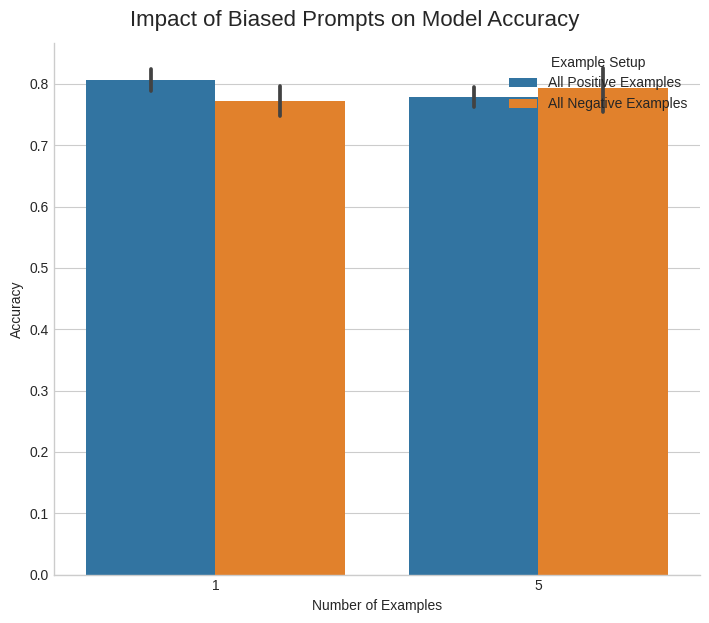

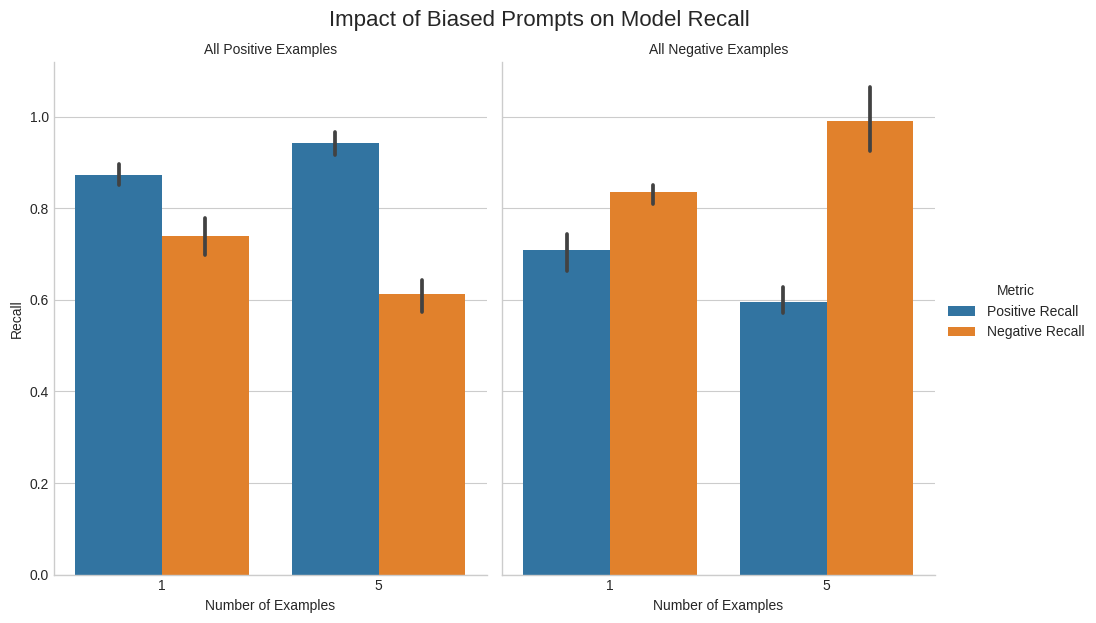

In [21]:
# ===================================================================
# 2. PLOT 2a: ACCURACY COMPARISON
# ===================================================================
plt.style.use('seaborn-v0_8-whitegrid')

g_acc = sns.catplot(
    data=exp2_df,
    x='n_shots',
    y='accuracy',
    hue='setup',
    kind='bar',
    height=6,
    aspect=1.2,
    errorbar='ci', # Show 95% confidence intervals
    legend=False # We will add a custom legend
)
g_acc.fig.suptitle('Impact of Biased Prompts on Model Accuracy', fontsize=16, y=1.03)
g_acc.set_axis_labels("Number of Examples", "Accuracy")
plt.legend(title='Example Setup', loc='upper right')
plt.savefig('/kaggle/working/biased_prompting_accuracy.png', dpi=100, bbox_inches='tight')
plt.show()


# ===================================================================
# 3. PLOT 2b: RECALL COMPARISON
# ===================================================================
# To plot both recalls, we first "melt" the DataFrame to a long format
exp2_df_melted = exp2_df.melt(
    id_vars=['run', 'n_shots', 'setup'], 
    value_vars=['positive_recall', 'negative_recall'],
    var_name='metric', 
    value_name='recall_score'
)
# Make the legend labels cleaner
exp2_df_melted['metric'] = exp2_df_melted['metric'].replace({
    'positive_recall': 'Positive Recall', 
    'negative_recall': 'Negative Recall'
})

# Create a faceted plot: one subplot for each setup
g_recall = sns.catplot(
    data=exp2_df_melted,
    x='n_shots',
    y='recall_score',
    hue='metric',
    col='setup', # Create separate columns for each setup
    kind='bar',
    height=6,
    aspect=0.8,
    errorbar='ci'
)
g_recall.fig.suptitle('Impact of Biased Prompts on Model Recall', fontsize=16, y=1.03)
g_recall.set_axis_labels("Number of Examples", "Recall")
g_recall.set_titles("{col_name}") # Set subplot titles
g_recall.legend.set_title("Metric")
plt.savefig('/kaggle/working/biased_prompting_recall.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
# Plot 3
plt.figure(figsize=(10, 6))
sns.lineplot(data=exp3_df, x='n_shots', y='accuracy', hue='setup', style='setup', markers=True, dashes=True, lw=2.5)
plt.title('Impact of Example Length on Model Accuracy', fontsize=16)
plt.xlabel('Number of Shots (n)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(shots_to_test_exp3) # Set x-ticks to only 1 and 5
plt.legend(title='Example Type')
plt.grid(True, alpha=0.5)
plt.savefig('/kaggle/working/length_few_shot_accuracy.png', dpi=100)
plt.show()

In [ ]:
# Baseline evaluation on test set
# ============================================================
print("\n" + "="*50)
print("BASELINE MODEL (NO FINE-TUNING) - TEST SET")
print("="*50)

X_test_prompts_baseline = test_reviews.apply(generate_test_prompt, axis=1) #X_test.apply
X_test_df_baseline = pd.DataFrame(X_test_prompts_baseline, columns=["text"])
y_test_pred_baseline, y_test_proba_baseline = predict_with_proba(X_test_df_baseline, model, tokenizer)

baseline_results = evaluate_with_roc(y_test_reviews, y_test_pred_baseline, 
                                    y_pred_proba=y_test_proba_baseline) #y_test_true

In [ ]:
y_test_proba_baseline

In [ ]:
print("BASELINE MODEL - K-FOLD EVALUATION")
print("="*50)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results_baseline = []

df_kfold_reset = df_kfold.reset_index(drop=True)
y_strat = (df_kfold_reset["sentiment"] == "positive").astype(int)

for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(df_kfold_reset, y_strat)):
    X_val_fold = df_kfold_reset.iloc[val_idx].reset_index(drop=True)
    
    print(f"\n{'#'*50}")
    print(f"# Baseline Fold {fold_idx + 1}/5")
    print(f"{'#'*50}")
    print(f"Val: {len(X_val_fold)}")
    
    y_val_true = X_val_fold["sentiment"].values
    X_val_test_prompts_baseline = X_val_fold.apply(generate_test_prompt, axis=1)
    X_val_test_baseline = pd.DataFrame(X_val_test_prompts_baseline, columns=["text"])
    y_val_pred_baseline, y_val_proba_baseline = predict_with_proba(X_val_test_baseline, model, tokenizer)
    
    baseline_eval = evaluate_with_roc(y_val_true, y_val_pred_baseline, 
                                     y_pred_proba=y_val_proba_baseline, fold_num=fold_idx + 1)
    fold_results_baseline.append(baseline_eval)

In [ ]:
print("BASELINE MODEL SUMMARY (NO FINE-TUNING)")
print("="*50)

accuracies_baseline = [r['accuracy'] for r in fold_results_baseline]
f1_scores_baseline = [r['f1_score'] for r in fold_results_baseline]
roc_aucs_baseline = [r['roc_auc'] for r in fold_results_baseline if r['roc_auc'] is not None]

print(f"\nAccuracy: {np.mean(accuracies_baseline):.4f} (+/- {np.std(accuracies_baseline):.4f})")
print(f"F1-Score: {np.mean(f1_scores_baseline):.4f} (+/- {np.std(f1_scores_baseline):.4f})")
print(f"ROC-AUC: {np.mean(roc_aucs_baseline):.4f} (+/- {np.std(roc_aucs_baseline):.4f})")

print("\nPer-Fold Baseline Results:")
for i, (acc, f1, auc) in enumerate(zip(accuracies_baseline, f1_scores_baseline, roc_aucs_baseline)):
    print(f"Fold {i+1:2d}: Accuracy={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

In [ ]:
print("Training Fine-tuned Model (Once on Full Dataset)")
print("="*50)

# Generate prompts for entire k-fold dataset
X_train_prompts = X_train.apply(generate_train_prompt, axis=1).tolist()
X_val_prompts = X_eval.apply(generate_train_prompt, axis=1).tolist()

# Create datasets using HuggingFace Dataset
train_data = Dataset.from_dict({"text": X_train_prompts})
eval_data = Dataset.from_dict({"text": X_val_prompts})

print(f"Train dataset size: {len(train_data)}")
print(f"Eval dataset size: {len(eval_data)}")

# Reload model
model = Gemma3ForCausalLM.from_pretrained(
    GEMMA_PATH, torch_dtype=compute_dtype, attn_implementation="eager",
    low_cpu_mem_usage=True, device_map=device
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# LoRA config
peft_config = LoraConfig(
    lora_alpha=32, lora_dropout=0.05, r=64, bias="none",
    task_type="CAUSAL_LM", target_modules="all-linear",
)

# Training config with validation
training_arguments = SFTConfig(
    output_dir="logs/finetuned_model",
    num_train_epochs=1,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    optim="adamw_torch_fused",
    save_steps=100,
    load_best_model_at_end=True,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True if compute_dtype == torch.float16 else False,
    bf16=True if compute_dtype == torch.bfloat16 else False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.02,
    group_by_length=False,
    eval_strategy="steps",
    eval_steps=25,
    eval_accumulation_steps=1,
    lr_scheduler_type="constant",
    report_to="none",
    packing=False,
    dataset_kwargs={"add_special_tokens": False, "append_concat_token": True}
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    processing_class=tokenizer,
    args=training_arguments,
)


In [ ]:
# Train once
trainer.train()

# Extract training history
history = trainer.state.log_history
#fold_histories.append(history)

In [ ]:
# Save the trained model
trained_model_path = "logs/finetuned_model/final_model"
trainer.model.save_pretrained(trained_model_path)
print(f"Trained model saved to {trained_model_path}")

del model, trainer
torch.cuda.empty_cache()

In [ ]:
# Final Test Evaluation
# ============================================================
print("\n" + "="*50)
print("FINAL TEST SET EVALUATION")
print("="*50)


# Load the trained model once
finetuned_model = AutoModelForCausalLM.from_pretrained(
    trained_model_path, device_map=device, torch_dtype=compute_dtype
)
finetuned_model.config.use_cache = False
finetuned_model.config.pretraining_tp = 1


X_test_prompts_finetuned = test_reviews.apply(generate_test_prompt, axis=1)
X_test_finetuned = pd.DataFrame(X_test_prompts_finetuned, columns=["text"])
y_test_pred_finetuned, y_test_proba_finetuned = predict_with_proba(X_test_finetuned, finetuned_model, tokenizer)

finetuned_results = evaluate_with_roc(y_test_reviews, y_test_pred_finetuned, 
                                    y_pred_proba=y_test_proba_finetuned)


In [ ]:
import matplotlib.pyplot as plt

# ============================================================
# Plot the ROC Curve for the Fine-Tuned Model on the Test Set
# ============================================================

plt.figure(figsize=(10, 8))

# Check if the results dictionary contains the necessary data
if 'fpr' in finetuned_results and 'tpr' in finetuned_results and 'roc_auc' in finetuned_results:
    
    # --- KEY CHANGE: Use the pre-calculated values from your dictionary ---
    fpr = finetuned_results['fpr']
    tpr = finetuned_results['tpr']
    roc_auc = finetuned_results['roc_auc']
    # --- END OF KEY CHANGE ---

    # Plot the ROC curve for the fine-tuned model
    plt.plot(fpr, tpr, 
             label=f"Fine-tuned Model (AUC = {roc_auc:.3f})", 
             linewidth=2, color='blue')

    # Plot the random classifier line for reference
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', linewidth=2)

    # Add labels, title, and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Fine-tuned Model on Test Set')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    # Save and show the plot
    plt.savefig('/kaggle/working/roc_curve_finetuned_test_set.png', dpi=100, bbox_inches='tight')
    print("ROC curve plot for the fine-tuned model saved!")
    plt.show()

else:
    print("The 'finetuned_results' dictionary is missing 'fpr', 'tpr', or 'roc_auc' keys.")

In [ ]:
print("Evaluating Fine-tuned Model on K-Fold Validation Sets")
print("="*50)

# Load the trained model once
finetuned_model = AutoModelForCausalLM.from_pretrained(
    trained_model_path, device_map=device, torch_dtype=compute_dtype
)
finetuned_model.config.use_cache = False
finetuned_model.config.pretraining_tp = 1

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
df_kfold_reset = df_kfold.reset_index(drop=True)
y_strat = (df_kfold_reset["sentiment"] == "positive").astype(int)
fold_results = []

for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(df_kfold_reset, y_strat)):
    X_val_fold = df_kfold_reset.iloc[val_idx].reset_index(drop=True)
    
    print(f"\n{'#'*50}")
    print(f"# Evaluating Fold {fold_idx + 1}/5")
    print(f"{'#'*50}")
    print(f"Val: {len(X_val_fold)}")
    
    y_val_true = X_val_fold["sentiment"].values
    
    # Predict on validation
    X_val_test_prompts = X_val_fold.apply(generate_test_prompt, axis=1)
    X_val_test = pd.DataFrame(X_val_test_prompts, columns=["text"])
    y_val_pred, y_val_proba = predict_with_proba(X_val_test, finetuned_model, tokenizer)
    
    # Evaluate fold
    fold_eval = evaluate_with_roc(y_val_true, y_val_pred, y_pred_proba=y_val_proba, fold_num=fold_idx + 1)
    fold_results.append(fold_eval)

In [ ]:
# Plot training AND validation loss for fine-tuned model
# ============================================================
plt.figure(figsize=(14, 5))

if history:
    losses = [h.get('loss') for h in history if 'loss' in h]
    eval_losses = [h.get('eval_loss') for h in history if 'eval_loss' in h]
    
    plt.subplot(1, 2, 1)
    if losses:
        plt.plot(losses, linewidth=2, color='blue', label='Training Loss')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title('Training Loss - Fine-tuned Model')
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    plt.subplot(1, 2, 2)
    if eval_losses:
        plt.plot(eval_losses, linewidth=2, color='red', label='Validation Loss')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title('Validation Loss - Fine-tuned Model')
        plt.grid(True, alpha=0.3)
        plt.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_loss.png', dpi=100, bbox_inches='tight')
print("Training/Validation loss plot saved!")
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

if history:
    # Extract training loss and steps
    train_history = [h for h in history if 'loss' in h]
    train_steps = [h['step'] for h in train_history]
    train_losses = [h['loss'] for h in train_history]

    # Extract validation loss and steps
    eval_history = [h for h in history if 'eval_loss' in h]
    eval_steps = [h['step'] for h in eval_history]
    eval_losses = [h['eval_loss'] for h in eval_history]
    
    # Plot training loss
    if train_losses:
        plt.plot(train_steps, train_losses, linewidth=2, color='blue', label='Training Loss')
    
    # Plot validation loss
    if eval_losses:
        # Use markers to highlight the less frequent validation points
        plt.plot(eval_steps, eval_losses, linewidth=2, color='red', 
                 marker='o', linestyle='--', label='Validation Loss')
    
    # Add plot titles and labels
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss During Fine-Tuning')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Save the combined plot
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_validation_loss.png', dpi=100, bbox_inches='tight')
    print("Combined Training and Validation loss plot saved!")
    plt.show()
else:
    print("History object is empty. Cannot generate plot.")

In [ ]:
# Plot ROC curves for all folds
# ============================================================
plt.figure(figsize=(10, 8))
for fold_idx, result in enumerate(fold_results):
    if result['fpr'] and result['tpr']:
        plt.plot(result['fpr'], result['tpr'], 
                label=f"Fold {fold_idx + 1} (AUC={result['roc_auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - 5-Fold Cross-Validation')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.savefig('/kaggle/working/roc_curves_kfold.png', dpi=100, bbox_inches='tight')
print("ROC curves plot saved!")
plt.show()


In [ ]:
#k-fold finetuned
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
df_kfold_reset = df_kfold.reset_index(drop=True)
y_strat = (df_kfold_reset["sentiment"] == "positive").astype(int)
fold_results = []

# ===================================================================
# 3. K-Fold Cross-Validation Loop
# ===================================================================
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(df_kfold_reset, y_strat)):
    print(f"\n{'='*25} FOLD {fold_idx + 1}/5 {'='*25}")

    # 1. Split data for the current fold
    X_train_fold = df_kfold_reset.iloc[train_idx]
    X_val_fold = df_kfold_reset.iloc[val_idx]

    # 2. Create Datasets
    train_dataset = Dataset.from_dict({"text": X_train_fold.apply(generate_train_prompt, axis=1).tolist()})
    
    # 3. Load a FRESH model for each fold
    # Reload model
    model = Gemma3ForCausalLM.from_pretrained(
        GEMMA_PATH, torch_dtype=compute_dtype, attn_implementation="eager",
        low_cpu_mem_usage=True, device_map=device
    )
    model.config.use_cache = False
    model.config.pretraining_tp = 1

    peft_config = LoraConfig(
        lora_alpha=32, lora_dropout=0.05, r=64, bias="none",
        task_type="CAUSAL_LM", target_modules="all-linear",
    )
    '''
    training_arguments = SFTConfig(
        output_dir=f"logs/finetuned_model_fold_{fold_idx+1}",
        num_train_epochs=5, per_device_train_batch_size=1,
        gradient_accumulation_steps=8, optim="adamw_torch_fused",
        save_strategy="no", logging_steps=50, learning_rate=2e-4,
        bf16=True, warmup_ratio=0.02, dataset_text_field="text", packing=False,
    )
    '''
    training_arguments = SFTConfig(
        output_dir="logs/finetuned_model",
        num_train_epochs=1,
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={"use_reentrant": False},
        per_device_train_batch_size=1,
        gradient_accumulation_steps=8,
        optim="adamw_torch_fused",
        save_steps=100,
        load_best_model_at_end=False,
        logging_steps=100,
        learning_rate=2e-4,
        weight_decay=0.001,
        fp16=True if compute_dtype == torch.float16 else False,
        bf16=True if compute_dtype == torch.bfloat16 else False,
        max_grad_norm=0.3,
        max_steps=-1,
        warmup_ratio=0.02,
        group_by_length=False,
        eval_strategy="no", 
        save_strategy="epoch", 
        lr_scheduler_type="constant",
        report_to="none",
        packing=False,
        dataset_kwargs={"add_special_tokens": False, "append_concat_token": True}
    )
    # 5. Initialize and run the trainer
    trainer = SFTTrainer(
            model=model, train_dataset=train_dataset, peft_config=peft_config,
            processing_class=tokenizer, args=training_arguments
        )

    print(f"Starting training for Fold {fold_idx + 1}...")
    trainer.train()

    # 6. Evaluate the model on the validation set for this fold
    print(f"Evaluating Fold {fold_idx + 1}...")
    y_val_true = X_val_fold["sentiment"].values
    X_val_test = pd.DataFrame(X_val_fold.apply(generate_test_prompt, axis=1), columns=["text"])
    
    y_val_pred, y_val_proba = predict_with_proba(X_val_test, trainer.model, tokenizer)
    
    fold_eval = evaluate_with_roc(y_val_true, y_val_pred, y_pred_proba=y_val_proba, fold_num=fold_idx + 1)
    fold_results.append(fold_eval)

    # 7. Clean up memory
    del model, trainer
    torch.cuda.empty_cache()

# ===================================================================
# 4. Aggregate and Display Final K-Fold Results
# ===================================================================
print(f"\n{'='*25} K-FOLD CROSS-VALIDATION SUMMARY {'='*25}")

# MODIFIED: Collect and summarize F1-score as well
accuracies = [res['accuracy'] for res in fold_results]
roc_aucs = [res['roc_auc'] for res in fold_results]
f1_scores = [res['f1_score'] for res in fold_results]

print(f"Average Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Average ROC AUC:  {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}")
print(f"Average F1-Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

In [ ]:
# Summary Statistics
# ============================================================
print("\n" + "="*50)
print("5-FOLD CROSS-VALIDATION SUMMARY")
print("="*50)

# Baseline results
accuracies_baseline = [r['accuracy'] for r in fold_results_baseline]
f1_scores_baseline = [r['f1_score'] for r in fold_results_baseline]
roc_aucs_baseline = [r['roc_auc'] for r in fold_results_baseline if r['roc_auc'] is not None]

print("\n--- BASELINE (NO FINE-TUNING) ---")
print(f"Accuracy: {np.mean(accuracies_baseline):.4f} (+/- {np.std(accuracies_baseline):.4f})")
print(f"F1-Score: {np.mean(f1_scores_baseline):.4f} (+/- {np.std(f1_scores_baseline):.4f})")
print(f"ROC-AUC: {np.mean(roc_aucs_baseline):.4f} (+/- {np.std(roc_aucs_baseline):.4f})")

# Fine-tuned results
accuracies = [r['accuracy'] for r in fold_results]
f1_scores_list = [r['f1_score'] for r in fold_results]
roc_aucs = [r['roc_auc'] for r in fold_results if r['roc_auc'] is not None]

print("\n--- FINE-TUNED MODEL ---")
print(f"Accuracy: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")
print(f"F1-Score: {np.mean(f1_scores_list):.4f} (+/- {np.std(f1_scores_list):.4f})")
print(f"ROC-AUC: {np.mean(roc_aucs):.4f} (+/- {np.std(roc_aucs):.4f})")

print("\nPer-Fold Results:")
print(f"{'Fold':<6} {'Baseline Acc':<15} {'FT Acc':<15} {'Baseline F1':<15} {'FT F1':<15} {'Baseline AUC':<15} {'FT AUC':<15}")
print("-" * 90)
for i in range(len(fold_results)):
    print(f"{i+1:<6} {accuracies_baseline[i]:<15.4f} {accuracies[i]:<15.4f} "
          f"{f1_scores_baseline[i]:<15.4f} {f1_scores_list[i]:<15.4f} "
          f"{roc_aucs_baseline[i]:<15.4f} {roc_aucs[i]:<15.4f}")

In [ ]:
!pip list | grep -E "pandas|numpy|umap-learn|hdbscan|bertopic|gensim|scikit-learn|sentence-transformers|tensorflow|optuna|nltk|matplotlib|seaborn"

In [ ]:
#TRY FINETUNING FOR IMDB50K Data
# 2. Create Datasets
train_dataset = Dataset.from_dict({"text": train_10k.apply(generate_train_prompt, axis=1).tolist()})

# 3. Load a FRESH model for each fold
# Reload model
model = Gemma3ForCausalLM.from_pretrained(
    GEMMA_PATH, torch_dtype=compute_dtype, attn_implementation="eager",
    low_cpu_mem_usage=True, device_map=device
)
model.config.use_cache = False
model.config.pretraining_tp = 1

peft_config = LoraConfig(
    lora_alpha=32, lora_dropout=0.05, r=64, bias="none",
    task_type="CAUSAL_LM", target_modules="all-linear",
)
'''
training_arguments = SFTConfig(
    output_dir=f"logs/finetuned_model_fold_{fold_idx+1}",
    num_train_epochs=5, per_device_train_batch_size=1,
    gradient_accumulation_steps=8, optim="adamw_torch_fused",
    save_strategy="no", logging_steps=50, learning_rate=2e-4,
    bf16=True, warmup_ratio=0.02, dataset_text_field="text", packing=False,
)
'''
training_arguments = SFTConfig(
    output_dir="logs/finetuned_model",
    num_train_epochs=1,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    optim="adamw_torch_fused",
    save_steps=100,
    load_best_model_at_end=False,
    logging_steps=100,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True if compute_dtype == torch.float16 else False,
    bf16=True if compute_dtype == torch.bfloat16 else False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.02,
    group_by_length=False,
    eval_strategy="no", 
    save_strategy="epoch", 
    lr_scheduler_type="constant",
    report_to="none",
    packing=False,
    dataset_kwargs={"add_special_tokens": False, "append_concat_token": True}
)
# 5. Initialize and run the trainer
trainer = SFTTrainer(
        model=model, train_dataset=train_dataset, peft_config=peft_config,
        processing_class=tokenizer, args=training_arguments
    )

In [ ]:
# Train once
trainer.train()

# Extract training history
history = trainer.state.log_history
#fold_histories.append(history)

In [ ]:
# Save the trained model
trained_model_path = "logs/finetuned_model/final_model"
trainer.model.save_pretrained(trained_model_path)
print(f"Trained model saved to {trained_model_path}")

del model, trainer
torch.cuda.empty_cache()

In [ ]:
# Load the trained model once
finetuned_model = AutoModelForCausalLM.from_pretrained(
    trained_model_path, device_map=device, torch_dtype=compute_dtype
)
finetuned_model.config.use_cache = False
finetuned_model.config.pretraining_tp = 1


X_test_prompts_finetuned = test_reviews.apply(generate_test_prompt, axis=1)
X_test_finetuned = pd.DataFrame(X_test_prompts_finetuned, columns=["text"])
y_test_pred_finetuned, y_test_proba_finetuned = predict_with_proba(X_test_finetuned, finetuned_model, tokenizer)

finetuned_results = evaluate_with_roc(y_test_reviews, y_test_pred_finetuned, 
                                    y_pred_proba=y_test_proba_finetuned)